In [1]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import pearsonr, poisson, wishart, multivariate_normal, norm, vonmises, multivariate_t, rice
from scipy.special import laguerre, i0, i1
# from dw_tools      import multivariatet as mvt

In [2]:
plt.rcParams.update({'font.size': 14})

## Summary
- Yes, skew is real and expected and reflects both depletion of the ground state and the appearance of new state(s) with different structure factors.
- Removing skew by scaling against the OFF data slightly degrades map quality (as measured by MSE or correlation relative to the true map), but it is generally not a large effect.
- I calculated optimal weights. They're a little different from what we use now in that they incorporate a phase error term in the denominator.
It seems like we can actually obtain an expression for the posterior distribution of the excited state structure factor given ON and OFF amplitudes, with the excited state fraction and correlation between ES and GS structure factors are hyperparameters.

## Introduction
Consider a pair of normalized structure factors $\left(E_1, E_{3}\right)$, with $E_1=(E_{1x}, E_{1y})$, and $E_{3}=(E_{3x}, E_{3y})$. Under the double-Wilson model, their distribution is jointly normal, $\sim N\left((0,0,0,0),C\right)$, with 

$$
C = 
\frac{\Sigma}{2}
\begin{bmatrix}
1 & 0 & r & 0 \\
0 & 1 & 0 & r \\
r & 0 & 1 & 0 \\
0 & r & 0 & 1  
\end{bmatrix}
$$

This can be ON and OFF, or ES and GS (here mostly the latter). The notation is such that $\left<|E_1|^2\right>=\left<E_{1x}^2+E_{1y}^2\right>=\Sigma$. For actual normalized structure factors, rather than $F$'s, $\Sigma=1$.

A word on notation: ```r``` and ```rx``` below both refer to $r$ above: they are correlation coefficients between real or imaginary components of two structure factors. I use ```r``` to refer to correlation with a reference data set from another crystal, and ```rx``` for correlations expected within a crystal, in particular between ground and excited states.

### Conditioning on a known structure factor amplitude
Now, let's examine what happens when we know one of the structure factors, e.g. $E_3$ (we can set one of the phases, e.g., $\phi_3$ to 0, or any other number, without loss of generality). When we have a known value for $E_3=(E_{3x}, E_{3y})$, the conditional distribution of $E$ becomes a bivariate normal with mean $\mu = r E_{3}$, with $r$ playing the role of $r_{DW}$ in the double-wilson model, and covariance matrix 

$$C_{1|3} = \frac{\Sigma}{2}
\begin{bmatrix}
1-r^2 & 0 \\
0 & 1-r^2
\end{bmatrix}
$$

It is helpful to write this in polar coordinates using $E_1 = R_1 \left(\cos(\phi_1),\sin(\phi_1)\right)$ and $\mu = r E_3 = R_3 \left(\cos(\phi_3),\sin(\phi_3)\right)$, such that

$$
\begin{align}
P\left(R_1,\phi_1 | R_3, \phi_3\right) & =  R_1 \frac{1}{2 \pi \sqrt{\det(C_{1|3})}} * 
                                       \exp\left(
                                           -\frac{1}{2}
                                           \left(R_1\cos(\phi_1)-R_3\cos(\phi_3), 
                                                 R_1\sin(\phi_1)-R_3\sin(\phi_3)
                                           \right)
                                           C_{1|3}^{-1}
                                           \left(R_1\cos(\phi_1)-R_3\cos(\phi_3), 
                                                 R_1\sin(\phi_1)-R_3\sin(\phi_3)
                                           \right)^T
                                       \right)\\
                                       & = 
                                       R_1 \frac{1}{2 \pi \sqrt{\det(C_{1|3})}} * 
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 (\cos(\phi_1)\cos(\phi_3)-
                                                                      \sin(\phi_1)\sin(\phi_3))}
                                                            {\Sigma(1-r^2)}          
                                           \right) \\
                                       & = 
                                        \frac{R_1}{\pi \Sigma (1-r^2)}  
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 \cos(\phi_1-\phi_3)}{\Sigma(1-r^2)}          
                                           \right)
\end{align}                                           
$$

where we use that $C_{1|3}^{-1} = \frac{2}{\Sigma} \frac{1}{1-r^2}$ and $\det(C_{1|3}) = \left(\frac{\Sigma}{2}(1-r^2)\right)^2$. Note, again, that the definition of $R_3$ above has $r$ absorbed in it.

We can marginalize over $\Delta\phi = \phi_1-\phi_3$,

$$
\begin{align}
P\left(R_1 | R_3\right) & = \int_{0}^{2\pi} d\Delta\phi
                                 \frac{R_1}{\pi \Sigma (1-r^2)} * 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                     +\frac{R_1 R_3 \cos(\Delta\phi)}{\Sigma(1-r^2)}          
                                 \right) \\
                        & = \frac{2 R_1}{\Sigma (1-r^2)} 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                 \right)
                            I_0\left(
                                \frac{2 R_1 R_3}{\Sigma(1-r^2)}          
                            \right)
\end{align}                                           
$$

which is the Rice distribution. For comparison to Bricogne (1999), his $R_B$ is our $R_1$, his $r_B$ is our $R_3=r|E_3|$, and his $\Sigma_B$ is $\frac{\Sigma}{2}(1-r^2)$, our per-term conditional variance (I added the $B$ subscripts to indicate "Bricogne").

**To Do** Add marginal distribution for phases.

#### Sampling
Let's consider sampling from the joint distribution first:

In [3]:
rng = default_rng()
rx  = 0.95
mean = np.array([0,0,0,0])
cov = 0.5*\
    np.asarray([[ 1, rx, 0,  0 ],\
                [rx, 1,  0,  0 ],\
                [0,  0,  1,  rx],\
                [0,  0,  rx, 1 ]])
vals  = rng.multivariate_normal(mean,cov,100000)

**Or**, sampling from a joint conditional distribution, conditional on some other structure factor both structure factors of interest are correlated with (see section 2 of **6_Bivariate_conditional_amplitude_phase_dists**):

In [4]:
rng = default_rng()
r   = 0.7
rx  = 0.9
mean= np.asarray([0.5,0.5,0,0])
cov = 0.5*\
      np.asarray([[ 1-r**2, rx-r**2, 0,      0],\
                  [rx-r**2, 1 -r**2, 0,      0],
                  [0,       0,       1 -r**2, rx-r**2],\
                  [0,       0,       rx-r**2, 1 -r**2]])
vals  = rng.multivariate_normal(mean,cov,100000)

In the random-diffuse Coppens model, identifying the ground-state structure factors $E^{off}=E^{gs}$ with $E_1$, and the excited-state structure factors $E^{es}$ with $E_3$,

$E^{on} = p E^{es} + (1-p) E^{gs}$

In [5]:
p = 0.2
E_gs   = vals[:,0] + 1j * vals[:,2]
E_es   = vals[:,1] + 1j * vals[:,3]
E_off  = E_gs
E_on   = (1-p)*E_gs + p*E_es
phi_on = np.angle(E_off)
phi_off= np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

**Or**, we can directly sample $E^{es}$ given $E^{gs}$ (with $\phi^{gs}=0$ without loss of generality):

In [6]:
rng  = default_rng()
rx   = 0.95
p    = 0.2
E_gs = 1 + 1j*0

mean= rx * np.asarray([np.real(E_gs),np.imag(E_gs)])
cov = 0.5*np.asarray([[ 1-rx**2,        0],\
                      [0,        1 -rx**2]])
vals  = rng.multivariate_normal(mean,cov,10000)

E_es   = vals[:,0] + 1j * vals[:,1]
E_off  = E_gs
E_on   = (1-p)*E_gs + p*E_es
phi_on = np.angle(E_off)
phi_off= np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

This third sampling method is the one we will use in the remainder of this notebook.

### Criteria for difference maps:
We want to achieve two objectives:
- minimize map MSE error relative to the true difference map
- minimize absolute correlation with the OFF map


Does it make sense to minimize absolute correlation with the ground state? We observe that under the double-Wilson model, the expected value of $E^{on}=pE^{es}+(1-p)E^{gs}$, 

$$\mathbb{E}(E^{on})=\left(1-p+pr_{DW}\right)E^{off} = \left(1-p(1-r_{DW})\right)E^{off} = \left(1-\theta\right)E^{off}$$

which defines $\theta=p(1-r_{DW})$. The expected amplitude, $\mathbb{E}(|E^{on}|)$, is given by the mean of the corresponding Rice distribution (yielding an expression which is usually numerically very close to $(1-\theta)$. This expected amplitude is smaller than $|E^{off}|$ (except when $p=0 \ or\ p=1\ or\ r_{DW}=1$). This is a real effect, in principle observable in diffraction patterns (with crystal heating a special case of the same effect). In difference maps, this effect shows up as negative covariance with the ground state. This is indeed true: the ground state is depleted in time-resolved X-ray experiments.

There are, however, cases in which removal of correlation with the OFF map _is_ desirable. For example, there are systematic biases in ratiometric approaches to estimating ON-OFF differences. A program procedure like SCALEIT, moreover, is often used to  remove overall scaling errors and effects of temperature or other sources of disorder resulting in global differences in anisotropic B-factors. We'll see below that removal of such effects generally has only a small effect on MSE. 

#### MSE map error and Covariance with another map
Let's examine the case of two sets of structure factors, $F=(A,B)$ and $F'=(A',B')$ such that

$$\rho(x) = \sum_h A_h \cos(2\pi hx) + B_h \sin(2 \pi hx)$$ and likewise for $\rho'(x)$ are the corresponding maps.
Then,

$$\Delta \rho(x) = \rho'(x) - \rho(x) = \sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)$$ 
with $\Delta A = A'-A$ etc. is their difference map.

The variance of this difference map is given by: 

\begin{align}
Var(\Delta \rho) & = \int_0^L dx (\Delta \rho(x))^2 = \int^L_0 dx \left(\sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)\right)^2 \\
& = \frac{L}{2}\sum_h \left((\Delta A_h)^2 + (\Delta B_h^2)\right) \\
\end{align} 

where we take into account that the mean value of $\cos^2$ or $\sin^2$ for sines and cosines that fit in the box an integer number of times, and that all other cross terms average to 0.

The covariance between two maps (e.g., $\rho(x)$ and $\Delta \rho(x)$) goes as 

\begin{align}
Cov(\rho,\Delta \rho) & =\int dx \rho(x) \Delta \rho(x) = \int dx \left(\sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)\right)\left(\sum_h A_h \cos(2\pi hx) + B_h \sin(2 \pi hx)\right) \\
& = \frac{L}{2}\sum_h (A\Delta A_h + B\Delta B_h) \\
\end{align} 
by the same arguments.

#### Application to difference maps
Applying this to our simulated data, we want to find scale coefficients $k$, $k'$ such that

- we minimize MSE between the approximate map $(k |F^{on}| - k'|F^{off}|)\exp(i\phi^{off})$, and the true map $F^{es} - F^{off}$


- we minimize (absolute) covariance of $(k |F^{on}| - k'|F^{off}|)\exp(i\phi^{off})$ with $F^{off}$

In [7]:
def calc_MSE(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, scale_by_p=True):
    '''
    As described above, this function calculates the expected mean square error (MSE) between a naive estimator 
    of the difference map and the true difference map. Measurement errors are not considered.
    '''
    if scale_by_p:
        pscale = p
    else:
        pscale = 1
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)
    MSE = np.mean(np.abs(deltaF_off_phased - pscale*(E_es-E_gs))**2)
    return MSE

def calc_Cov_off(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs):
    '''
    This function calculates the expected covariance between a estimates of the difference map 
    and the OFF map. Measurement errors are not considered.
    '''
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_gs)\
                     )
    return Cov_off

def calc_Corr_true(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs):
    '''
    This function calculates the expected correlation between estimates of the difference map 
    and the OFF map. Measurement errors are not considered.
    '''
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_es-E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_es-E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_es-E_gs)**2)
    return Cov_off/(np.sqrt(norm1*norm2))

def calc_mean_DoM(k, E_on_abs, E_off_abs):
    DoM = (k[0]*E_on_abs - k[1]*E_off_abs)
    return np.mean(DoM)

### Optimization of difference maps over $k$ and $k'$ (no measurement error).

In [8]:
nmax = 100
MSE_obs     = np.zeros((nmax,nmax))
cov_off_obs = np.zeros((nmax,nmax))
corr_true   = np.zeros((nmax,nmax))
mean_DoM    = np.zeros((nmax,nmax))
k_range = np.linspace(0.8,1.2,nmax)/p
for k1 in tqdm(range(0,nmax)):
    for k2 in range(0,nmax):
        k = [k_range[k1],k_range[k2]]
        MSE_obs[    k1,k2] = calc_MSE(      k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, scale_by_p=False)
        cov_off_obs[k1,k2] = calc_Cov_off(  k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
        corr_true[k1,k2]   = calc_Corr_true(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
        mean_DoM[   k1,k2] = calc_mean_DoM( k, E_on_abs, E_off_abs)

100%|████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s]


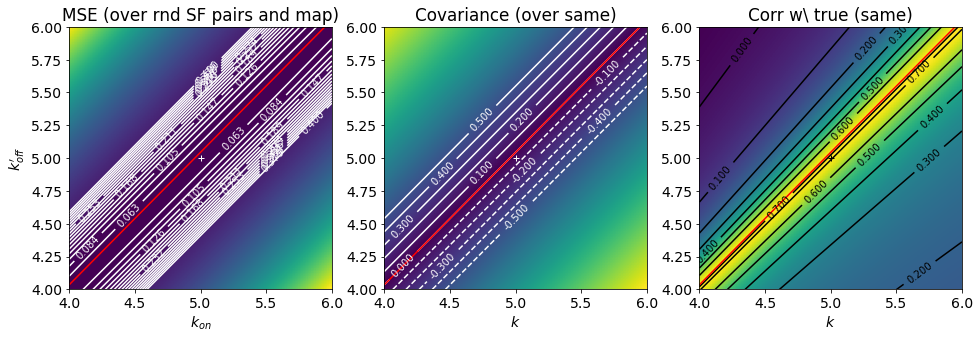

In [9]:
fig, _axs = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
extent = [k_range[0], k_range[-1], k_range[0], k_range[-1]]
axs = _axs.flatten()

axs[0].imshow(MSE_obs, origin='lower', extent=extent)
cs = axs[0].contour(MSE_obs,levels=np.linspace(0.0,0.4,20),colors='w', extent=extent)
axs[0].clabel(cs, inline=True, fontsize=10)
axs[0].plot(1/p,1/p,'w+')
axs[0].set_title("MSE (over rnd SF pairs and map)")
axs[0].set_xlabel(r"$k_{on}$") # validated
axs[0].set_ylabel(r"$k_{off}'$")

axs[1].imshow( np.abs(cov_off_obs), origin='lower', extent=extent)
cs=axs[1].contour(cov_off_obs,levels=np.linspace(-0.5,0.5,11),colors='w', extent=extent)
axs[1].clabel(cs, inline=True, fontsize=10)
axs[0].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[1].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[1].plot(1/p,1/p,'w+')
axs[1].set_title("Covariance (over same)")
axs[1].set_xlabel(r"$k$")
axs[1].set_xlim(k_range[[0,-1]])
axs[1].set_ylim(k_range[[0,-1]])

axs[2].imshow( corr_true, origin='lower', extent=extent)
cs=axs[2].contour(corr_true,levels=np.linspace(-1,1,21),colors='k', extent=extent)
axs[2].clabel(cs, inline=True, fontsize=10)
axs[2].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[2].plot(1/p,1/p,'k+')
axs[2].set_title("Corr w\ true (same)")
axs[2].set_xlabel(r"$k$")
plt.show()

Conclusions (again, without measurement error)
- The 0-covariance line goes, in good approximation, through the origin. That is, we only care about the $k/k'$ ratio and can set $k'=1/p$ for most purposes. Indeed, $k' = 1/p$ can yield (close to) minimal MSE (white plus signs in center of each image). This reduces the problem to 1D optimization.
- The 0-covariance line goes nearly through the point of minimum MSE: one can eliminate correlation with the OFF map without much loss of accuracy.


#### Expected MSE
A byproduct of the above calculation is that we can determine the MSE map error for the proposed $k(|E^{off}|, p, r)$ as a function of its arguments. This can be a consideration in the determination of map weights.

### The role of measurement error

In [13]:
def generate_dw_samples(rx, E_gs, nsamples):
    mean= rx * np.asarray([np.real(E_gs),np.imag(E_gs)])
    cov = 0.5*np.asarray([[ 1-rx**2,        0],\
                          [0,        1 -rx**2]])
    vals  = rng.multivariate_normal(mean,cov,nsamples)
    return vals

class on_off_samples:
  def __init__(self, vals, E_gs, p):
    self.E_gs     = E_gs
    self.E_es     = vals[:,0] + 1j * vals[:,1]
    self.E_off    = E_gs
    self.E_on     = (1-p)*E_gs + p*self.E_es
    self.phi_on   = np.angle(self.E_off)
    self.phi_off  = np.angle(self.E_on)
    self.E_off_abs = np.abs(self.E_off)
    self.E_on_abs  = np.abs(self.E_on)

In [11]:
def calc_MSE_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error, scale_by_p=True):
    '''
    As described above, this function calculates the expected mean square error (MSE) between a naive estimator 
    of the difference map and the true difference map. 
    '''
    if scale_by_p:
        pscale = p
    else:
        pscale = 1
    
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    MSE = np.mean(np.abs(deltaF_off_phased - pscale*(E_es-E_gs))**2)
    return MSE

def calc_Cov_off_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error):
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_gs)**2)
    return [Cov_off, Cov_off/(np.sqrt(norm1*norm2))]

def calc_Corr_true_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error):
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    Cov_true = np.mean(np.real(deltaF_off_phased) * np.real(E_es-E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_es-E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_es-E_gs)**2)
    return Cov_true/(np.sqrt(norm1*norm2))

#### Let's repeat our 2D optimization with meas error

In [14]:
rng  = default_rng()
rx   = 0.95
p    = 0.2
E_gs = 0.5 + 1j*0
y = on_off_samples(generate_dw_samples(rx, E_gs, nsamples=10000), E_gs, p)

In [17]:
sig_off =  0.0707
sig_on  =  0.0707
off_error = sig_off * np.random.normal(size=y.E_on_abs.shape) # E_off_abs is a scalar!
on_error  = sig_on  * np.random.normal(size=y.E_on_abs.shape )

nmax = 100
nmax2 = nmax # Used for validating image axes
MSE_obs     = np.zeros((nmax,nmax2))
corr_off_obs = np.zeros((nmax,nmax2))
corr_true   = np.zeros((nmax,nmax2))
mean_DoM    = np.zeros((nmax,nmax2))
k1_range = np.linspace(0.9,1.1,nmax)/p
k2_range = np.linspace(0.9,1.1,nmax2)/p
for k1 in tqdm(range(0,nmax)):
    for k2 in range(0,nmax2):
        k = [k1_range[k1],k2_range[k2]]
        MSE_obs[    k1,k2] = calc_MSE_w_meas_error(      k, y.E_on_abs, y.phi_off, y.E_off_abs, y.E_es, y.E_gs, \
                                                   on_error, off_error,scale_by_p=False)
        corr_off_obs[k1,k2] = calc_Cov_off_w_meas_error(  k, y.E_on_abs, y.phi_off, y.E_off_abs, y.E_es, y.E_gs, on_error, off_error)[1]
        corr_true[k1,k2]    = calc_Corr_true_w_meas_error(k, y.E_on_abs, y.phi_off, y.E_off_abs, y.E_es, y.E_gs, on_error, off_error)

100%|████████████████████████████████████████| 100/100 [00:17<00:00,  5.66it/s]


Let's check our samples to make sure everything is as expected, and calculate our scale factor to remove correlation of the difference map with OFF:

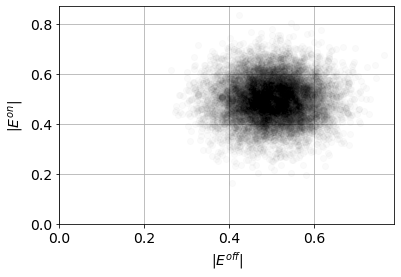

Estimated correction factor to eliminate correlation with OFF map: 1.00590


In [31]:
plt.plot(y.E_off_abs+off_error, y.E_on_abs+on_error,'ko',alpha=0.02)
plt.xlim((0,plt.xlim()[1]))
plt.ylim((0,plt.ylim()[1]))
plt.xlabel(r"$|E^{off}|$")
plt.ylabel(r"$|E^{on}|$")
plt.grid()
plt.show()

k_emp = np.mean(y.E_off_abs + off_error)/np.mean(y.E_on_abs + on_error)
print(f"Estimated correction factor to eliminate correlation with OFF map: {k_emp:.5f}")

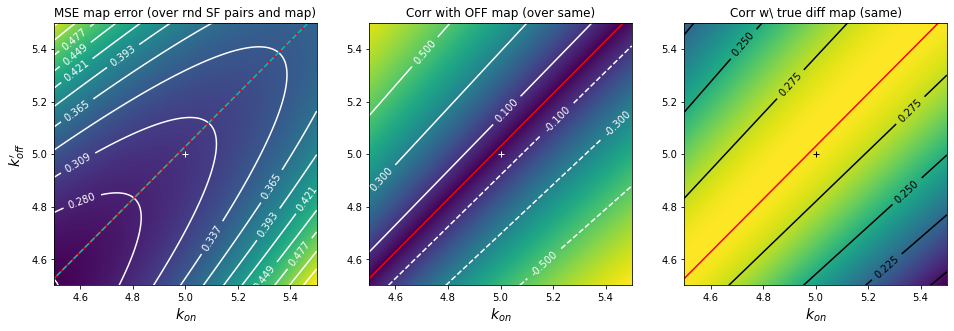

In [35]:
%matplotlib inline
fig, _axs = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
extent = [k1_range[0], k1_range[-1], k2_range[0], k2_range[-1]]
axs = _axs.flatten()

axs[0].imshow(      MSE_obs, origin='lower', extent=extent)
cs = axs[0].contour(MSE_obs, levels=np.linspace(0,np.amax(MSE_obs.flatten()),21),colors='w', extent=extent)
axs[0].clabel(cs, inline=True, fontsize=10)
axs[0].plot(1/p,1/p,'w+')
axs[0].plot(k_range[[0,-1]], k_emp * k_range[[0,-1]],'c--')
axs[0].set_title("MSE map error (over rnd SF pairs and map)")
axs[0].set_xlabel(r"$k_{on}$",fontsize=14)
axs[0].set_ylabel(r"$k_{off}'$",fontsize=14)
axs[0].set_xlim(k1_range[[0,-1]])
axs[0].set_ylim(k2_range[[0,-1]])

axs[1].imshow( np.abs(corr_off_obs), origin='lower', extent=extent)
cs=axs[1].contour(corr_off_obs,levels=np.linspace(-0.5,0.5,6),colors='w', extent=extent)
axs[1].clabel(cs, inline=True, fontsize=10)
axs[0].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[1].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[1].plot(1/p,1/p,'w+')
# axs[1].plot(k_range, 1.0293*k_range,'k:')
axs[1].set_title("Corr with OFF map (over same)")
axs[1].set_xlabel(r"$k_{on}$",fontsize=14)
axs[1].set_xlim(k1_range[[0,-1]])
axs[1].set_ylim(k2_range[[0,-1]])
# plt.scatter(cov_off_obs[np.abs(cov_off_obs<0.002)][:,0], cov_off_obs[np.abs(cov_off_obs<0.002)][:,1],'k.')
# plt.colorbar()

axs[2].imshow( corr_true, origin='lower', extent=extent)
cs=axs[2].contour(corr_true,levels=np.linspace(-1,1,81),colors='k', extent=extent)
axs[2].clabel(cs, inline=True, fontsize=10)
axs[2].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[2].plot(1/p,1/p,'k+')
# axs[1].plot(k_range, 1.0293*k_range,'k:')
axs[2].set_title("Corr w\ true diff map (same)")
axs[2].set_xlabel(r"$k_{on}$",fontsize=14)
# axs[2].set_xlim(k_range[[0,-1]])
# axs[2].set_ylim(k_range[[0,-1]])
plt.show()

### Optimal weights for difference maps
Let's say we have unbiased estimators $z_i$ of complex structure factors $F_i$ with true complex values $\mu_i$ and associated errors given by a covariance matrix $\Sigma_i$. We'll approximate the probability of $z_i$ given $\mu_i$ and $\Sigma_i$ as a normal distribution (this is not essential, I think). So, $z_i\sim N(\mu_i, \Sigma_i)$. For now, we'll work with generic dimensions $x$ and $y$.

A difference map consists of contributions from many structure factors with different amplitudes and phases. We want to find a set of weights such that $\sum_i w_i z_i$ approximates $\sum_i \mu_i$.

A natural loss function is the squared error in position in the complex plane. 

\begin{align}
S & = \left(\sum_i w_i z_{ix} - \sum_j \mu_{jx} \right)^2 + ...  \\
  & = \left(
            \sum_{i,j} w_i w_j z_{ix} z_{jx} - 2 \sum_{i,j} w_i z_{ix} \mu_{jx} + 
            \left( \sum_j \mu_{jx}
            \right)^2
      \right) + ... \\
\end{align}

To calculate the expectation value of this expression, we observe that 

$$
\mathbb{E}\left(z_{ix} z_{jx}\right) = \mathbb{E}\left((z_{ix}-\mu_{ix}+\mu_{ix}) (z_{jx}-\mu_{jx}+\mu_{jx})\right) = Cov(z_{ix}, z_{jx}) + \mu_{ix}\mu_{jx}
$$

Such that 

\begin{align}
\mathbb{E}S & = \sum_{i,j} w_i w_j \left(
                                        Cov(z_{ix}, z_{jx}) + \mu_{ix}\mu_{jx}
                                   \right) 
              - 2\sum_{i,j} w_i \mu_{ix} \mu_{jx} 
              +  \sum_{i,j}     \mu_{ix} \mu_{jx} + \ ... \\
            & = \sum_{i} w_i^2 \sigma^2_{ix} 
              + \left(
                  \sum_{i} (w_i-1) \mu_{ix}
                \right)^2
                + \ ...\\
\end{align}

This loss function has its optimum for weights which satisfy
$$
\frac{\partial\mathbb{E}S}{\partial w_i}
    = 2 w_i \sigma^2_{ix} + 2 \mu_{ix} \left(\sum_{j} (w_j - 1) \mu_{jx}\right)+\ ... =0
$$

Let $M_{ij} = \mu_{ix}\mu_{jx} + \mu_{iy}\mu_{jy}$ and $C_{ij} = \sigma^2_{ix} + \sigma^2_{iy}$ for $i=j$ and $0$ otherwise (or one could generalize this for correlated errors). Let $1_j=1$. Then at the optimum:

\begin{align}
\sum_j C_{ij} w_j + \sum_j M_{ij}w_j-\sum_j M_{ij} 1_j = 0 \ & \Rightarrow \ (C+M)w=M\cdot 1 \\
& \Rightarrow w= (C+M)^{-1}(M\cdot 1) \\
\end{align}

So far this is general. Let's apply this to maps. For maps, we should average $\mathbb{E}S $ over the map. In this case, all off-diagonal elements of $M$ become zero as all $i\neq j$ correspond to different spatial frequencies (I hope this is true--it's been a while!). That is, 

$$
    w_{h} = \frac{|F|^2}{|F|^2 + \sigma^2_F}=\frac{1}{1 + \sigma^2_F/|F|^2}
$$

It is interesting to note that
- for a smaller region of interest, there may, in general, be a better choice of weights.
- only relative error $\sigma_F/|F|$ matters in the end.

In general, $\sigma^2_F$ should consider both azimuthal and radial errors, $\delta r_i$ and $r \delta\varphi_i$ with variances $\sigma^2_{rad}$ and $\sigma^2_{\varphi}$. For a **difference map**, the radial component contains estimates of errors in $|F^{on}|$ and $|F^{off}|$, and the azimuthal components both estimates of variance in the phase difference between ON and OFF, and of the phase error in OFF. 

For difference maps, then, we can make the following substitutions:

$F \rightarrow \Delta = k |F^{on}| - |F^{off}|$

$\sigma^2_F \rightarrow \sigma^2_{\Delta} + \sigma^2_{azi}$, where $\sigma^2_{\Delta} = k^2 \sigma^2_{on} +\sigma^2_{off}$ and $\sigma^2_{azi} = \Delta^2 \sigma^2_{\varphi_{OFF}} + \frac{1}{2}p^2 (1-r_{DW}^2)$, so:

\begin{align}
w_h & = \frac{\Delta_h^2}{\Delta_h^2 + k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}+\Delta_h^2 \sigma^2_{\varphi_{h,OFF}} + \frac{1}{2}p^2 (1-r_{DW}^2)} \\
& = \frac{\Delta_h^2}{
          \Delta_h^2 \left( 1 + \sigma^2_{\varphi_{h,OFF}}        \right) + 
                     \left(k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}\right) + 
                     \frac{1}{2}p^2 (1-r_{DW}^2)
                     } \\
& \approx \frac{\Delta_h^2}{
          \Delta_h^2 \left( 1 + \sigma^2_{\varphi_{h,OFF}}        \right) + 
                     \left(k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}\right) + 
                     p\theta 
                     } < 1\\
\end{align}

We know everything in this expression by the time we need to evaluate it, except $\frac{1}{2}p^2 (1-r_{DW}^2) =  \frac{1}{2}p^2 (1-r_{DW})(1+r_{DW})\approx p^2(1-r_{DW}) = p\theta$. Although this is probably often _not_ the dominant term in the denominator, we'd have to make some guess for $p$, e.g. $p=0.2$. In addition, we need to errors in the phases of the OFF model--something available in principle (see http://www.phenix-online.org/pipermail/phenixbb/2016-February/022760.html).

## Posterior probability for excited state structure factors given $|E^{on}|$ and $|E^{off}|$

Complex $E^{on}$ conditional on $E^{off}=(|E^{off}|,0)$ with $\phi^{off}=0$, without loss of generality, follows a bivariate normal with mean $\left<E^{on}\right>=|E^{off}|(1-p+p\cdot r_{DW})$ and covariance $\frac{1}{2}p^2(1-r_{DW}^2)I$ under the Coppens random-diffuse model. Hence, $|E^{on}|$ follows $Rice\left(\nu=|E^{off}|(1-p+p\cdot r_{DW}), \sigma^2=\frac{1}{2}p^2(1-r_{DW}^2)\right)$. It's expectation value is given on https://en.wikipedia.org/wiki/Rice_distribution.

As a consequence, we can directly determine the posterior probability of $E^{es}$ given $|E^{on}|$ and $|E^{off}|$. This is very exciting, as $P\left(E^{es}\right)$ is a natural starting point for excited state refinement.

Specifically,

\begin{align}
P\left(E^{es}\Bigr| |E^{on}|, E^{off}\right) 
    & =\frac{P\left(E^{es}, |E^{on}|\Bigr| E^{off}\right)}{P\left(|E^{on}|\Bigr| E^{off}\right)}\\
    & =\frac{P\left(|E^{on}|\Bigr| E^{es}, E^{off}\right) P\left(E^{es}\Bigr| E^{off}\right)}{P\left(|E^{on}|\Bigr| E^{off}\right)}\\
     & =\frac{P\left(E^{es}\Bigr| E^{off}\right)}{P\left(|E^{on}|\Bigr| E^{off}\right)}\delta\left(
         |E^{on}|-|pE^{es}+(1-p)E^{off}|
     \right)\\
\end{align}

Assuming we know $p$, and, indeed, $|E^{on}|,|E^{off}|$, we can evaluate this expression.